In [82]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

from keras.models import *
from keras.layers import Activation, Conv2D, Dropout, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from os import listdir
from os.path import isfile, join

%matplotlib inline

## Utility functions

In [61]:
def create_dict_with_params(path):
    param_list = open(path, 'r').read().split('\n')
    param_list = list(map(lambda x: x.split(" = "), param_list))
    d = {x[0]:x[1] for x in param_list}
    int_params = ['batch_size', 'epochs', 'img_height', 'img_width',
                  'nb_train_samples', 'nb_validation_samples']
    for param in int_params:
        d[param] = int(d[param])
    d['without_augmentation'] = str_to_bool(d['without_augmentation'])
    if not d['without_augmentation']:
        gen_params = d['generator_params'][1:-1].split(",")
        new_d = {}
        for param in gen_params:
            key, value = param.split(" : ")
            new_d[key.strip()] = value
        gen_float_params  = ['height_shift_range', 'rotation_range',
                             'shear_range', 'width_shift_range', 'zoom_range']
        for param in gen_float_params:
            new_d[param] = float(new_d[param])
        new_d['horizontal_flip'] = str_to_bool(new_d['horizontal_flip'])
        d['generator_params'] = new_d
    return d

In [5]:
def str_to_bool(s):
    if s == 'True':
         return True
    elif s == 'False':
         return False
    else:
         raise ValueError("Cannot covert {} to a bool".format(s))

# Data processing

## images size reduction

In [173]:
def load_data(data_path, rows, cols, img_type = "jpg"):
    imgs = glob.glob(data_path + "\\*" + img_type)
    img_count = len(imgs)
    imgs_data = np.ndarray((img_count, rows, cols, 3), dtype = np.uint8)
    for i in range(img_count):
        imgs_data[i, :, :] =  mpimg.imread(imgs[i])
    return imgs_data

In [169]:
def resize_imgs(data, x1, x2, y1, y2, path, img_type = "jpg"):
    i = 1
    for img in data:
        im = Image.fromarray(img[x1:-x2, y1:-y2])
        im.save(path + str(i) + "." + img_type)
        i += 1

In [148]:
def apply_mask(path, mask_path, rows, cols, save_path, img_type = "jpg"):
    imgs = load_data(path, rows, cols, img_type)
    masks = load_data(mask_path, rows, cols, img_type)
    imgs = imgs.astype('float32')
    masks = masks.astype('float32')
    imgs /= 255
    masks /= 255
    masks[masks > 0.5] = 1
    masks[masks <= 0.5] = 0
    i = 1
    res = imgs * masks
    for img in res:
        print(img.shape)
        img = img * 255
        img = img.astype('uint8')
        img = Image.fromarray(img)
        img.save(save_path + str(i) + "." + img_type)
        i += 1

In [68]:
"""
inp_path_0 = "data/with_masks/0_512"
out_path_0 = "data/with_masks/0_256/"
img_width = 512
img_height = 512 

data = load_data(inp_path_0, img_width, img_height)
size_reduction(data, 256, 256, 256, 256, out_path_0)
"""

In [ ]:
"""
img_path_0 = "data/with_masks/0_256"
mask_path_0 = "data/with_masks/masks_0/"
save_path_0 = "data/with_masks/result_0/"

img_path_1 = "data/with_masks/1_256"
mask_path_1 = "data/with_masks/masks_1/"
save_path_1 = "data/with_masks/result_1/"

img_width = 256
img_height = 256 

apply_mask(img_path_0, mask_path_0, img_width, img_height, save_path_0, img_type = "jpg")
apply_mask(img_path_1, mask_path_1, img_width, img_height, save_path_1, img_type = "jpg")
"""

## data augmentation

In [7]:
def plots(ims, figsize=(12, 6), rows = 1):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0, 2, 3, 1))
    f = plt.figure(figsize = figsize)
    cols = len(ims) // rows if len(ims) % 2 == 0 else len(ims) // rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        plt.imshow(ims[i])

In [8]:
def create_generator(data_dir, batch_size, img_width, img_height,
                     rotation_range = 0, width_shift_range = 0,
                     height_shift_range = 0, shear_range = 0,
                     zoom_range = 0, horizontal_flip = False):
    
    datagen = ImageDataGenerator(
        rescale = 1./255, rotation_range = rotation_range, width_shift_range = width_shift_range,
        height_shift_range = height_shift_range, shear_range = shear_range, zoom_range = zoom_range,
        horizontal_flip = horizontal_flip)

    generator = datagen.flow_from_directory(
        data_dir, target_size = (img_width, img_height),
        batch_size = batch_size, class_mode = 'binary')

    return generator

Found 182 images belonging to 2 classes.


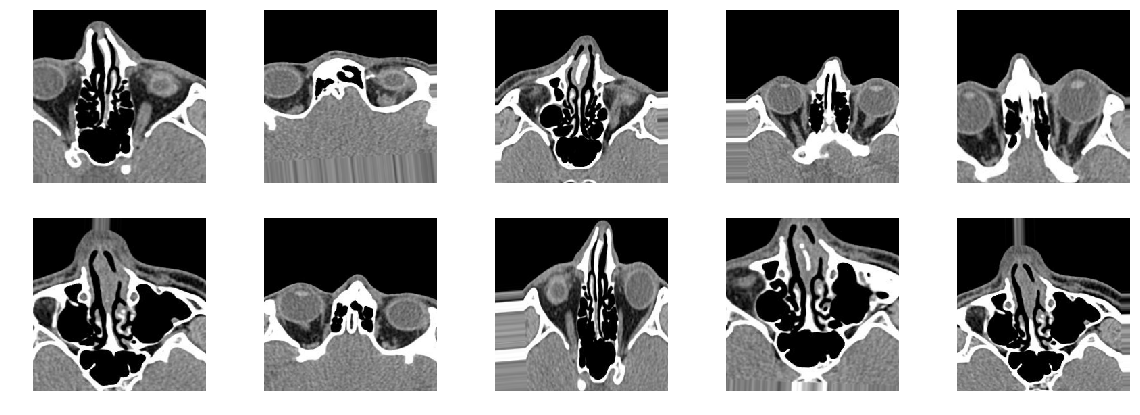

In [9]:
# data augmentation example
cfg_name = "cfg4.txt"
d = create_dict_with_params("cfg/" + cfg_name)
train_generator = create_generator(d["train_data_dir"], d["batch_size"],
                                   d["img_width"], d["img_height"], **d["generator_params"])
aug_images = [next(train_generator)[0][0] for i in range(10)]
plots(aug_images, figsize=(20,7), rows=2)

# Metrics

In [20]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [31]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [37]:
def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec) / (prec+rec + K.epsilon()))

# Model

In [47]:
def get_model(img_width, img_height):
    model = Sequential()
    model.add(Conv2D(32, 11 ,activation = 'relu', input_shape = (img_width, img_height, 3)))
    model.add(MaxPooling2D(pool_size=(3,3)))

    model.add(Conv2D(64, 3 ,activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, 3 ,activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, 3 ,activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    # model.add(Dropout(0.2))
    model.add(Dense(256, activation = 'relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
        optimizer='rmsprop',
        metrics=['accuracy', recall, precision, f1])
    return model

In [81]:
def create_logs(path, name, cfg_name, evaluation):
    info = "cfg name : " + cfg_name + "\n"
    for x in evaluation:
        info += (x[0] + " : " + str(np.round(x[1],3)) + "\n")
    with open(path + "/" + name + ".txt", 'w') as out:
        out.write(info[:-1])

In [165]:
def results():
    df = pd.DataFrame(columns = ["img_width", "img_height", "nb_train_samples", "nb_validation_samples",
                                 "epochs", "batch_size", "without_augmentation", "loss", "acc", "recall",
                                 "precision", "f1"])
    df = pd.DataFrame()
    onlyfiles = [f for f in listdir("results") if isfile(join("results", f))]
    for path in onlyfiles:
        f = open("results/" + path, 'r').read().split('\n')
        f = list(map(lambda x: x.split(" : "), f))
        d = {x[0]:x[1] for x in f}
        d_param = create_dict_with_params("cfg/" + d["cfg name"])
        del d["cfg name"]
        key_to_remove = ['train_data_dir', 'validation_data_dir', 'result_name']
        if not d_param["without_augmentation"]:
            del d_param["generator_params"]
        for i in key_to_remove:
            del d_param[i]
        
        d_all = {}
        d_all.update(d_param)
        d_all.update(d)
        df = df.append(d_all, ignore_index=True)
        for col in ["batch_size", "img_width", "img_height",
                    "epochs", "nb_train_samples", "nb_validation_samples"]:
            df[col] = df[col].astype('int')
        df["without_augmentation"] = df["without_augmentation"].astype(bool)
    return df

# Main

In [147]:
def main(cfg_name, img_width, img_height, train_data_dir, validation_data_dir,
         nb_train_samples, result_name, nb_validation_samples, epochs, batch_size,
         without_augmentation, generator_params = None):
    
    model = get_model(img_width, img_height)

    if without_augmentation:
        train_generator = create_generator(train_data_dir, batch_size,
                                           img_width, img_height)
    else:
        train_generator = create_generator(train_data_dir, batch_size,
                                           img_width, img_height, **generator_params)

    validation_generator = create_generator(validation_data_dir, batch_size, img_width, img_height)

    model.fit_generator(
            train_generator, steps_per_epoch = nb_train_samples // batch_size,
            epochs = epochs, validation_data = validation_generator,
            validation_steps = nb_validation_samples // batch_size)
    evaluation = list(zip(model.metrics_names, model.evaluate_generator(validation_generator,
                                                          nb_validation_samples / batch_size)))
    create_logs("results", result_name, cfg_name, evaluation)
    model.save_weights("results/weights/weights_" + result_name + ".h5")
    return model

In [162]:
cfg_name = "cfg_mask1.txt"
d = create_dict_with_params("cfg/" + cfg_name)
model = main(cfg_name = cfg_name, **d)

Found 111 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Epoch 1/15
150/150 [==============================] - 92s 611ms/step - loss: 1.7340 - acc: 0.8833 - recall: 0.0067 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 2/15
150/150 [==============================] - 99s 657ms/step - loss: 1.6656 - acc: 0.8967 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 3/15
150/150 [==============================] - 90s 601ms/step - loss: 1.7727 - acc: 0.8900 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 4/15
150/150 [==============================] - 90s 602ms/step - loss: 1.8268 - acc: 0.8867 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 5/15
150/150 [==============================] - 91s 605ms/step - loss: 1.7193 - acc: 0.8933 - recall: 0.0000e+00 - val_loss: 8.0590 - val_acc: 0.5000 - val_recall: 0.0000e+00
Epoch 6/15
150/150

In [59]:
cfg_name = "cfg2.txt"
d = create_dict_with_params("cfg/" + cfg_name)
model = main(cfg_name = cfg_name, **d)

Found 182 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Epoch 1/25
125/125 [==============================] - 631s 5s/step - loss: 3.0619 - acc: 0.5600 - recall: 0.2174 - precision: 0.1000 - f1: 0.1266 - val_loss: 8.4180 - val_acc: 0.4583 - val_recall: 0.8333 - val_precision: 0.4583 - val_f1: 0.5706
Epoch 2/25
125/125 [==============================] - 624s 5s/step - loss: 10.1074 - acc: 0.3660 - recall: 0.7920 - precision: 0.3660 - f1: 0.4808 - val_loss: 8.4182 - val_acc: 0.4583 - val_recall: 0.8333 - val_precision: 0.4583 - val_f1: 0.5706
Epoch 3/25
125/125 [==============================] - 634s 5s/step - loss: 10.0755 - acc: 0.3680 - recall: 0.8240 - precision: 0.3680 - f1: 0.4904 - val_loss: 8.4182 - val_acc: 0.4583 - val_recall: 0.8333 - val_precision: 0.4583 - val_f1: 0.5873
Epoch 4/25
125/125 [==============================] - 615s 5s/step - loss: 5.3236 - acc: 0.4920 - recall: 0.4500 - precision: 0.2327 - f1: 0.2833 - val_loss: 0.6857 - val_acc: 0.5417

In [168]:
results()

,acc,batch_size,epochs,f1,img_height,img_width,loss,nb_train_samples,nb_validation_samples,precision,recall,without_augmentation
0,0.542,4,25,0.542,512,512,8.547,182,48,0.542,0.708,True
1,0.833,4,25,0.653,512,512,0.388,500,48,0.75,0.611,False
2,0.875,2,15,0.681,256,256,0.428,182,48,0.667,0.708,True
3,0.958,2,15,0.778,256,256,0.13,500,48,0.833,0.75,False
4,0.5,2,15,0.0,256,256,8.059,111,10,0.0,0.0,True
5,0.5,2,15,0.0,256,256,8.059,300,10,0.0,0.0,False
